In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

# Per leggere/confrontare velocemente le immagini
def plot_rgb_distribution(images):
    num_imgs = len(images)
    plt.figure(figsize=(30,20))
    for i, image in enumerate(images) :
        
        # image = cv2.imread(path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR a RGB

        # Show the image
        plt.subplot(2, num_imgs, i+1)
        plt.imshow(image)

        # Extract 2-D arrays of the RGB channels: red, green, blue
        red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2]

        # Flatten the 2-D arrays of the RGB channels into 1-D
        red_pixels = red.flatten() / 255.0  # Normalizza i valori nel range [0, 1]
        green_pixels = green.flatten() / 255.0
        blue_pixels = blue.flatten() / 255.0

        # Calcola l'istogramma dei pixel per ogni canale
        red_px = np.histogram(red_pixels, bins=256, range=[0, 1])
        green_px = np.histogram(green_pixels, bins=256, range=[0, 1])
        blue_px = np.histogram(blue_pixels, bins=256, range=[0, 1])

        # Plot degli istogrammi
        plt.subplot(2,num_imgs,i+1+num_imgs)
        plt.plot(red_px[1][:256], red_px[0], color='r')
        plt.plot(green_px[1][:256], green_px[0], color='g')
        plt.plot(blue_px[1][:256], blue_px[0], color='b')
        plt.xticks(ticks=np.linspace(0, 1, 17), labels=range(0, 257, 16))
        plt.yscale('log')

    plt.show()


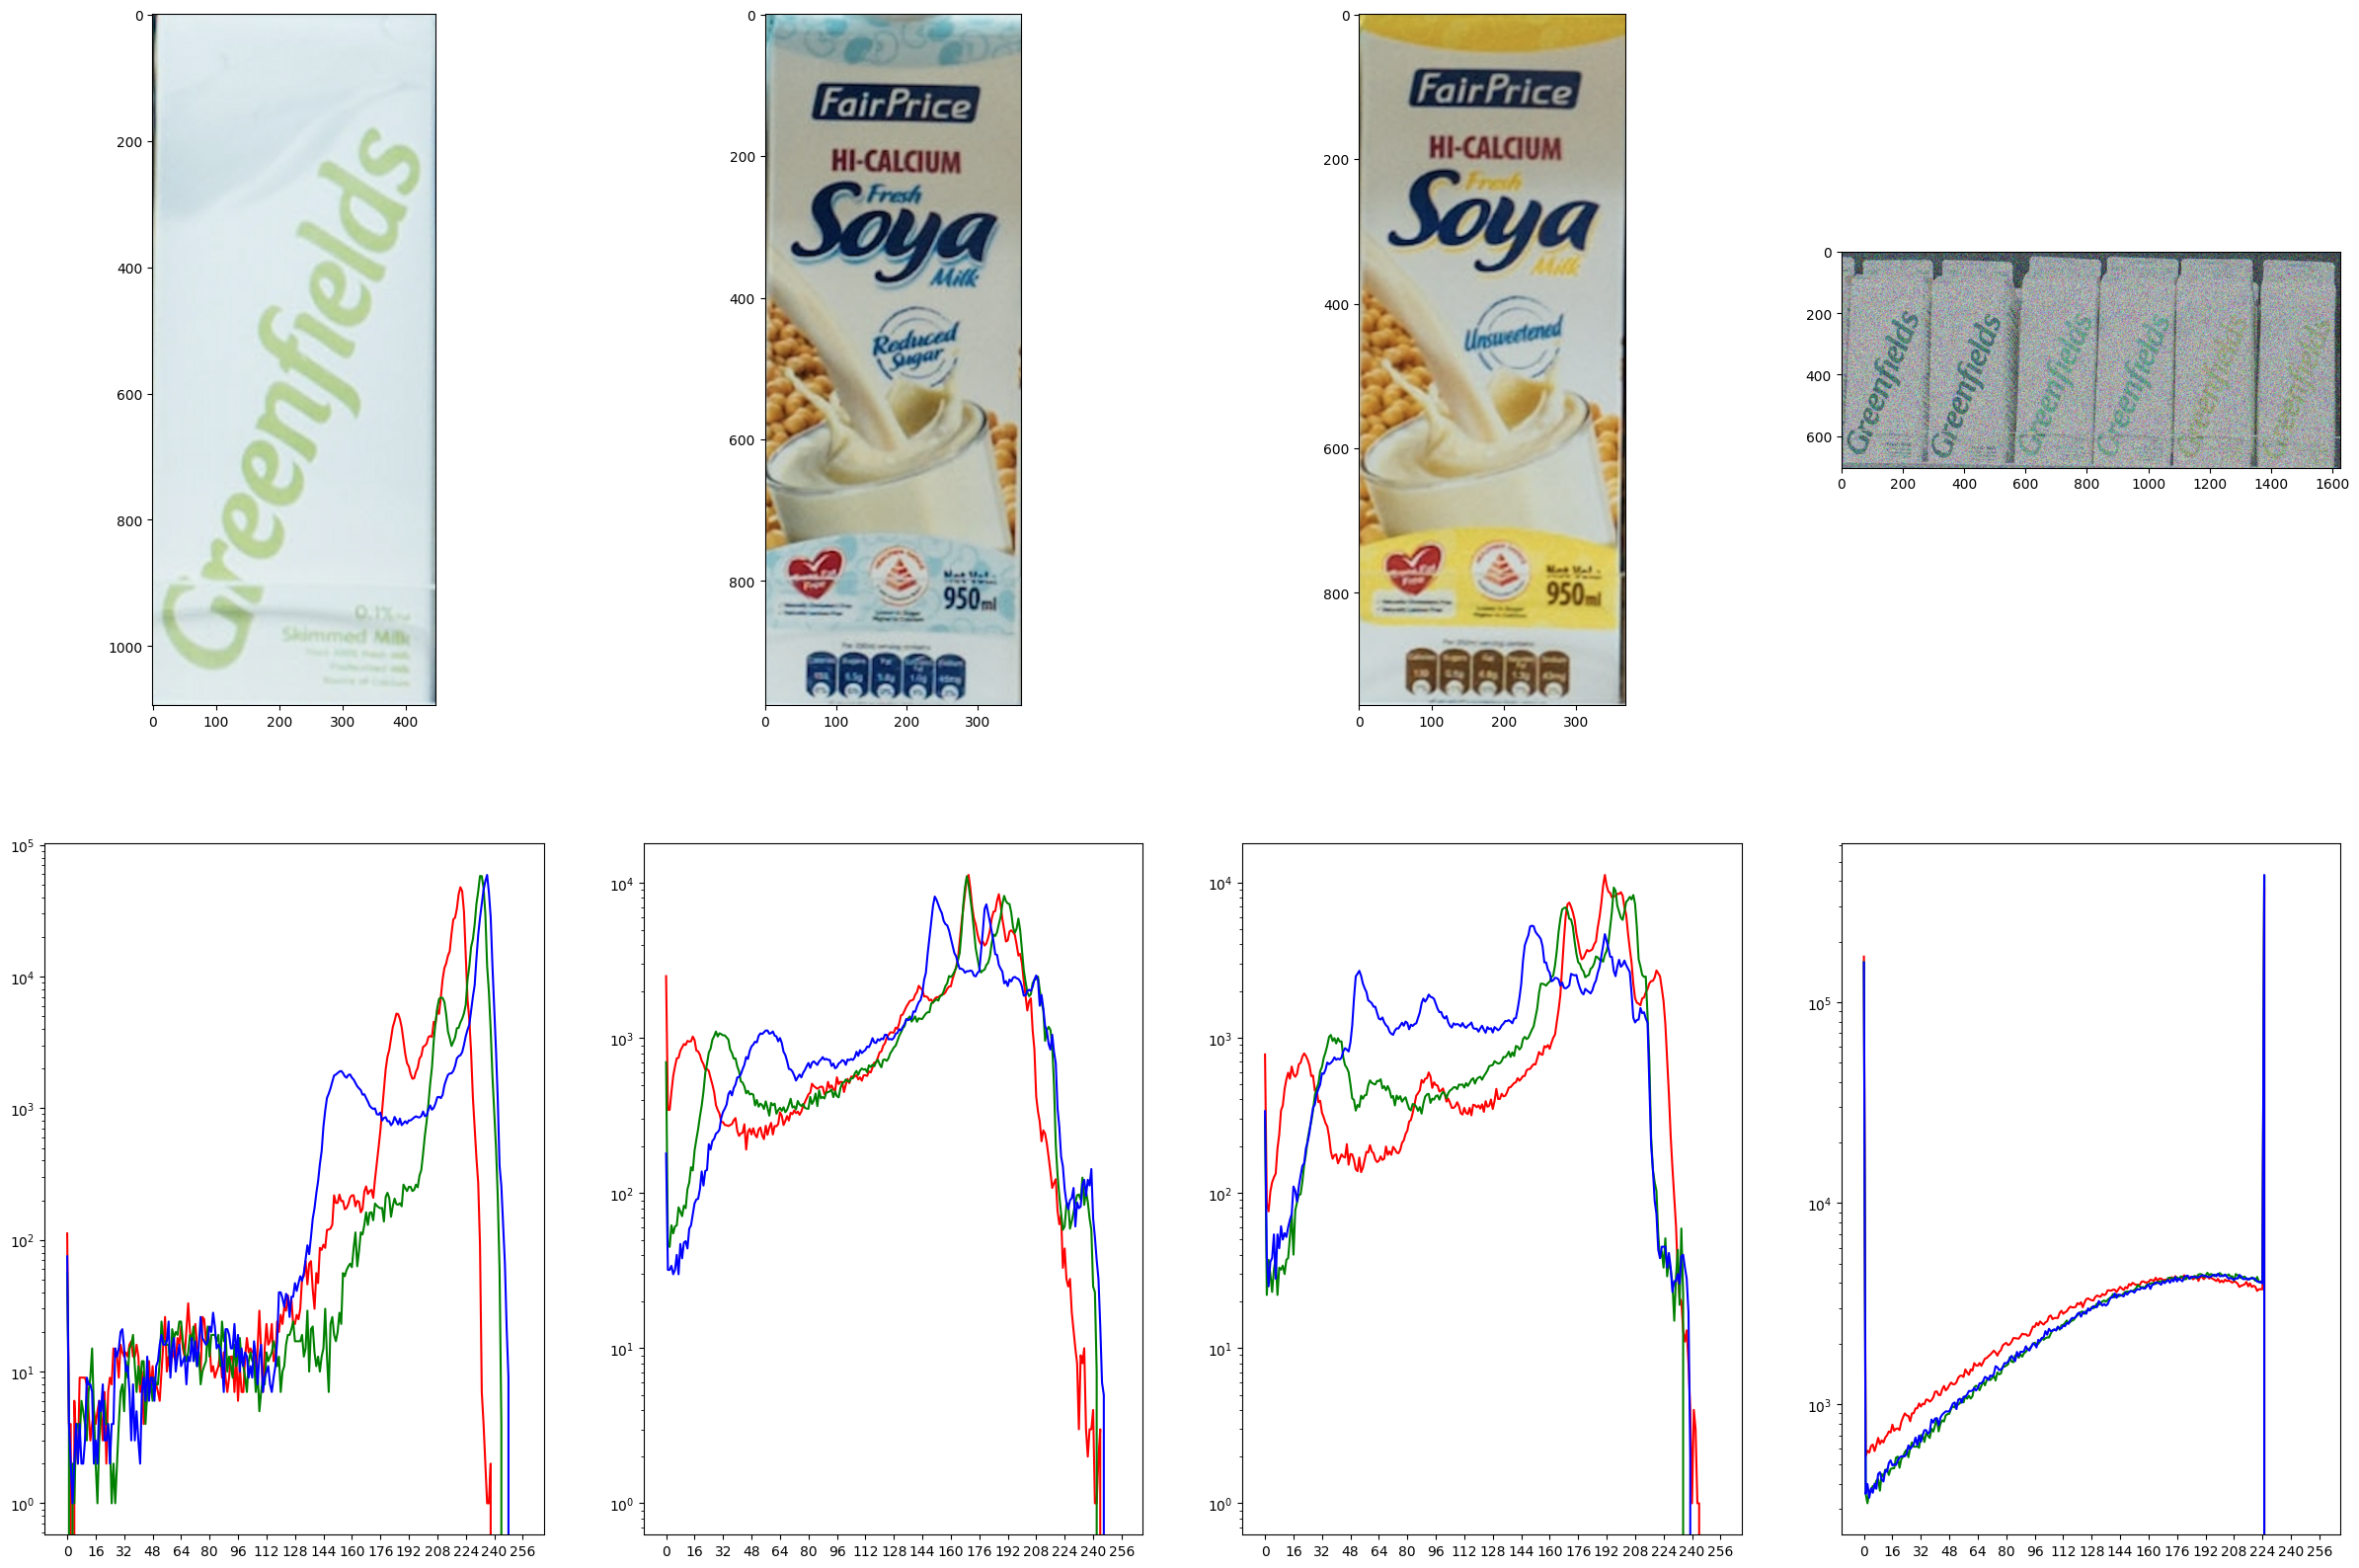

In [3]:
plot_rgb_distribution([cv2.imread(f'/Users/pelle/Desktop/ref{n}.png')[:,:,::-1] for n in [18, 23, 24]]+
                      [cv2.imread(f'/Users/pelle/Desktop/scene{n}.png')[:,:,::-1] for n in [12]])

In [4]:
# Per aggiungere il rumore e capire che rumore c'era originariamente
def add_noise_to_image(image, noise_type, parameters:dict):
    match noise_type:
        case "random" :
            '''
            parameter example
            {
                "intensity" : 20,
            }
            '''
            noise = np.random.normal(scale=parameters['intensity'], size=image.shape)
            noisy_image = np.clip(image - noise, 0, 225).astype(np.uint8)
            return noisy_image
        
        case _: ValueError("Unsupported noise type")
    return noisy_image

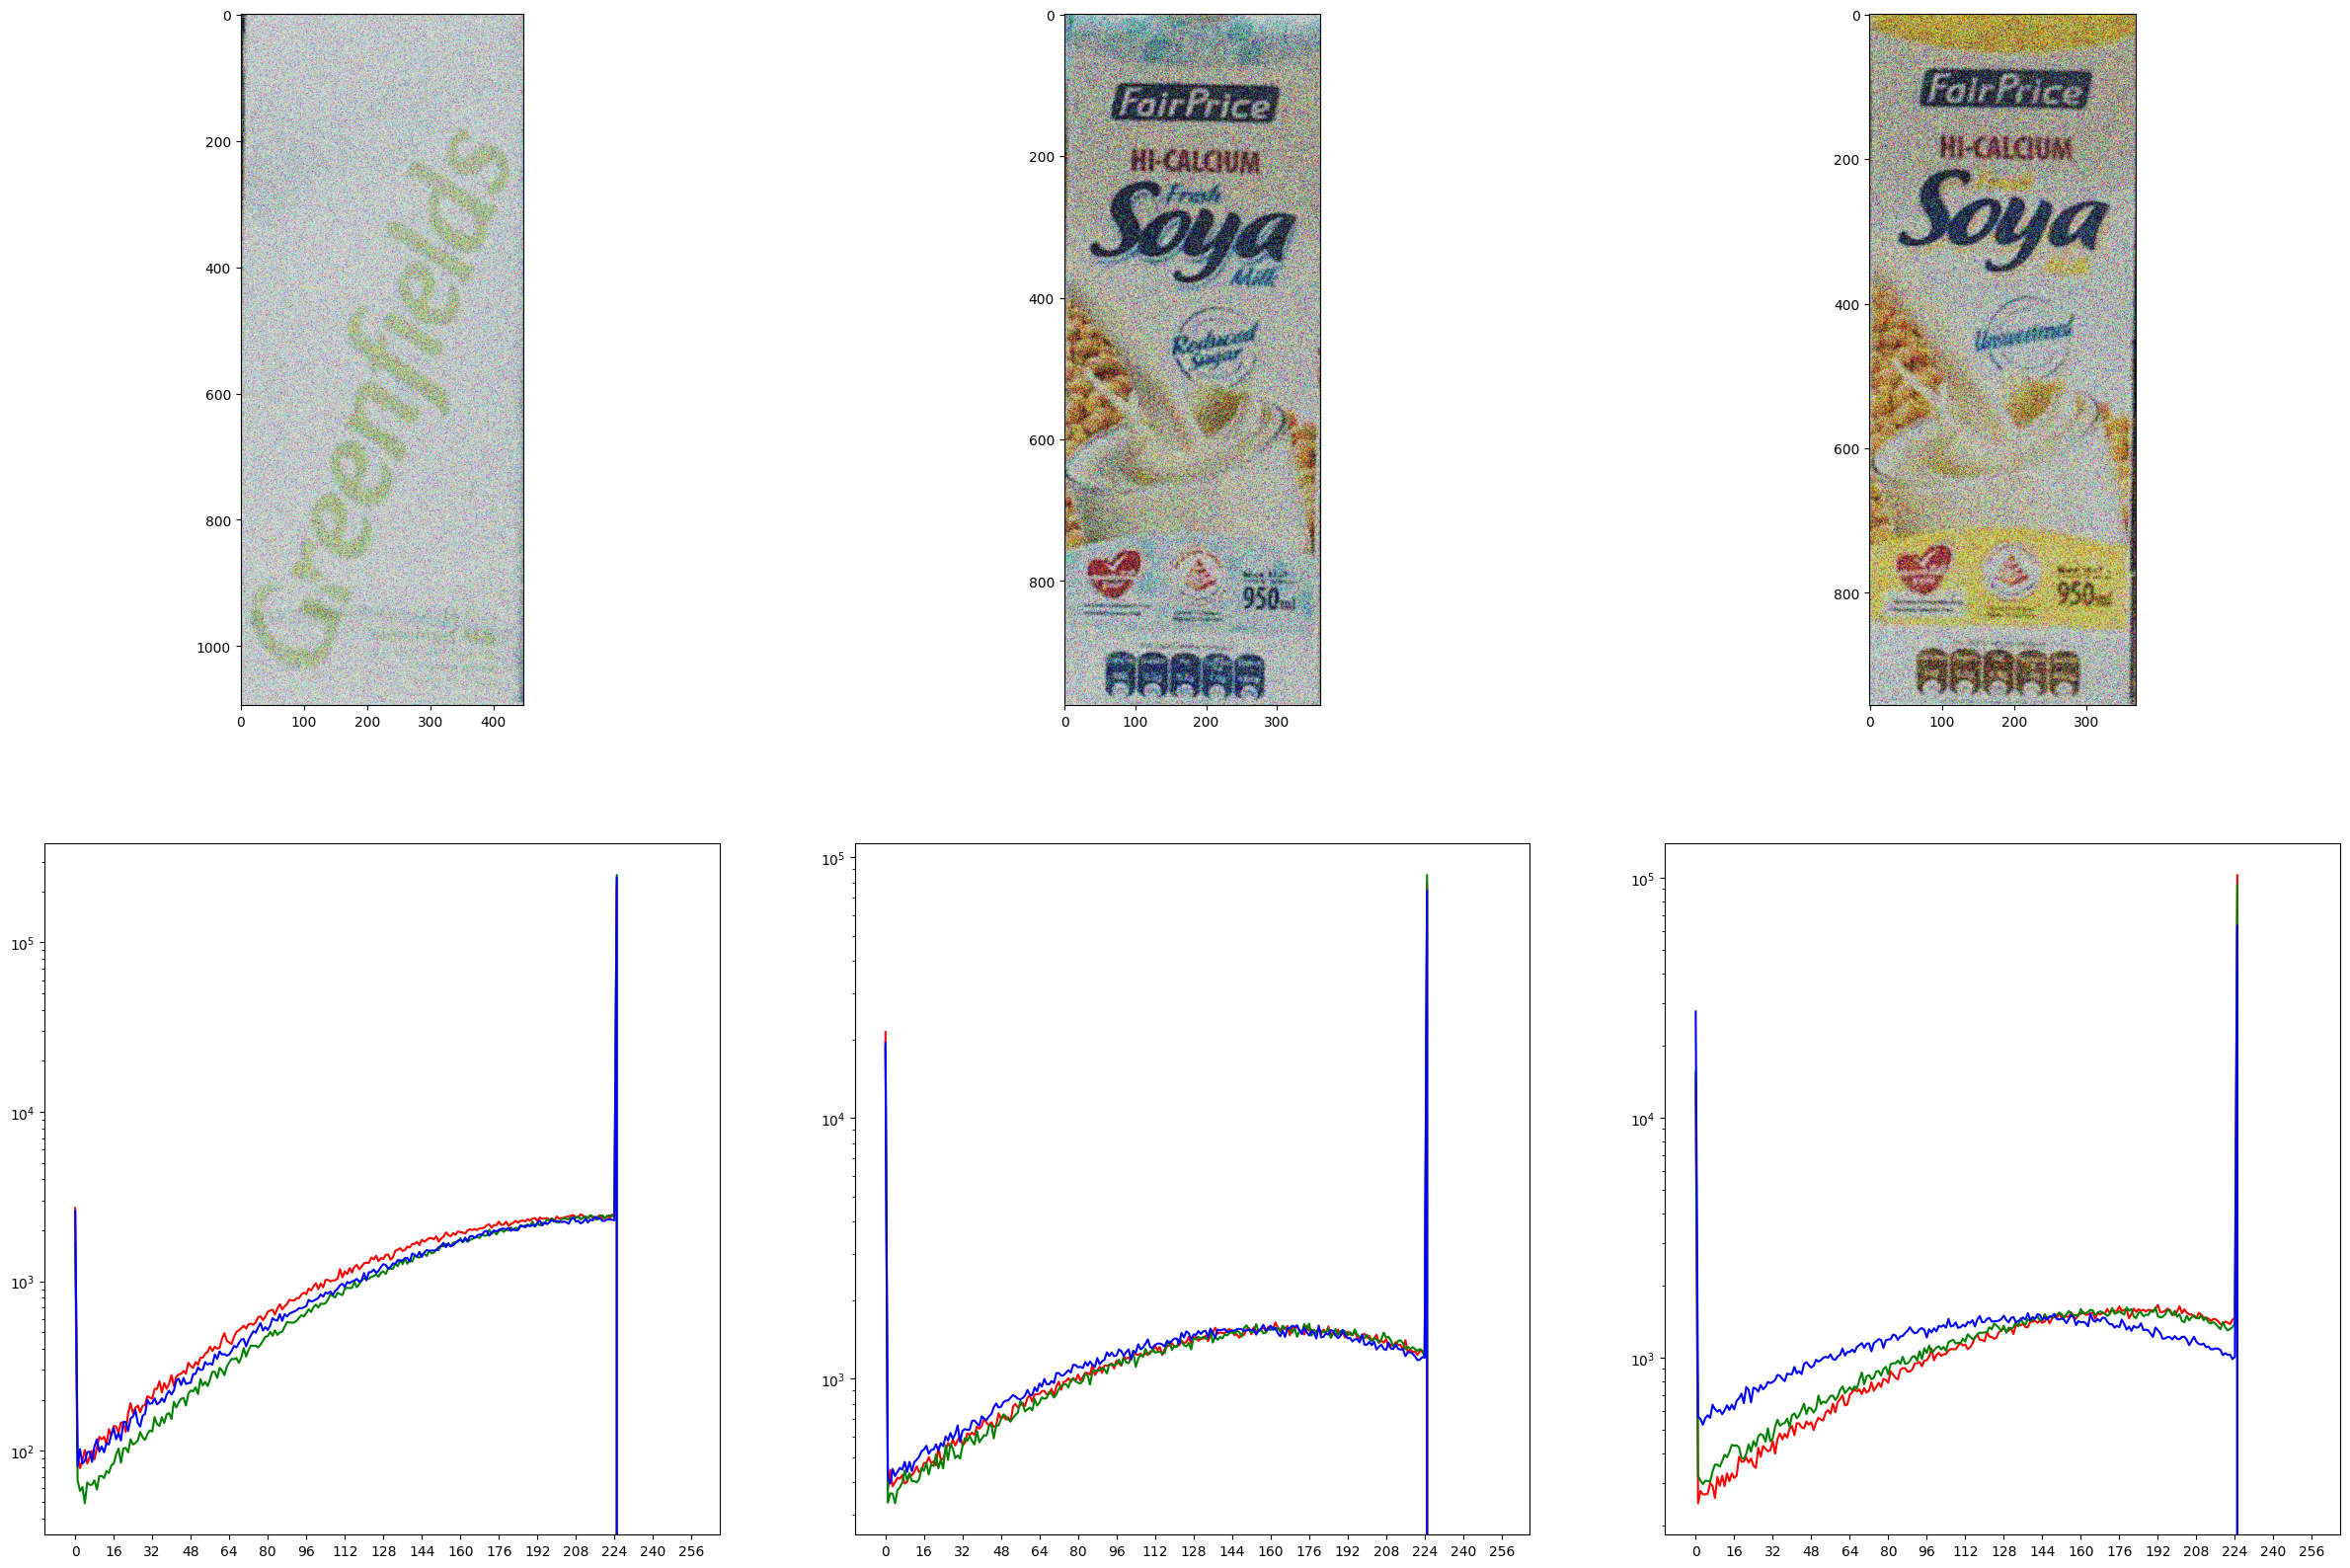

In [5]:
plot_rgb_distribution([
    add_noise_to_image(
        noise_type='random',
        image=cv2.imread(f'/Users/pelle/Desktop/ref{n}.png')[:,:,::-1], 
        parameters={"intensity":80}
    )
    for n in [18, 23, 24]
])

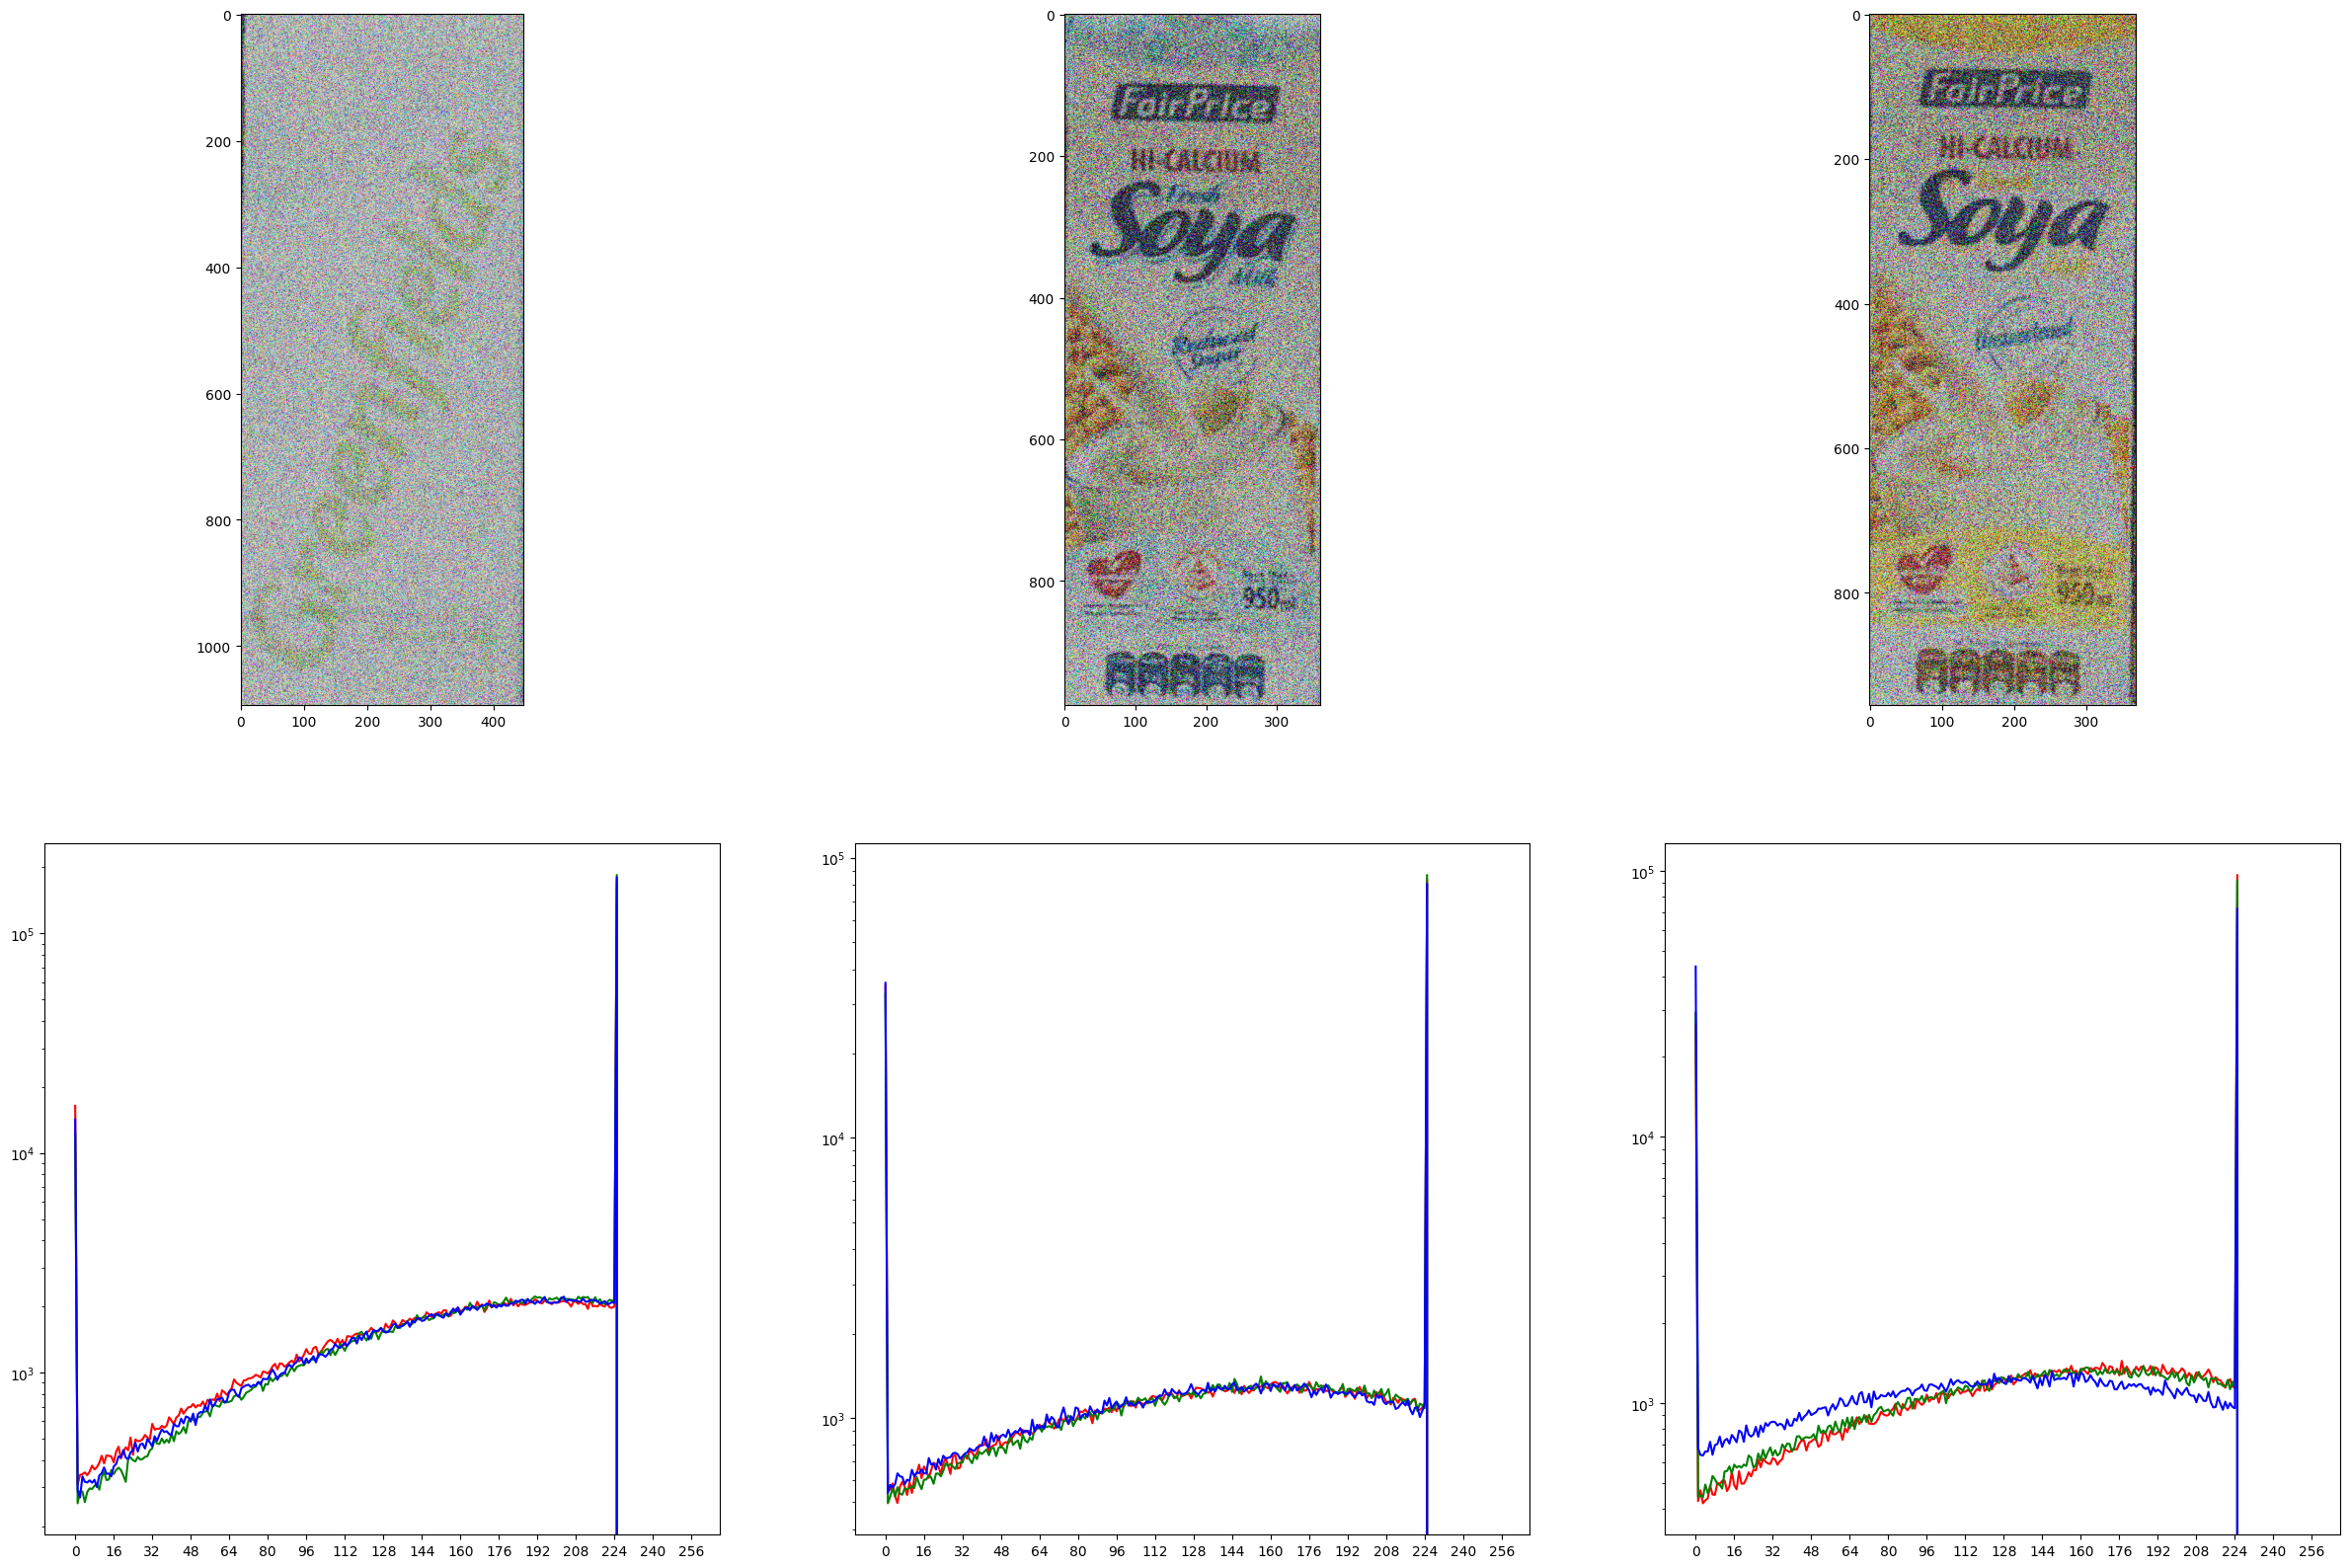

In [6]:
# Tentativo di aggiungere un noise che prima era stato tolto per provare a fare denoise
intensity = {"intensity":80}
plot_rgb_distribution([
        np.clip(
            add_noise_to_image(
                noise_type='random',
                image=cv2.imread(f'/Users/pelle/Desktop/ref{n}.png')[:,:,::-1], 
                parameters=intensity
            ) 
            + 
            np.random.normal(
                scale=intensity['intensity'], 
                size=cv2.imread(f'/Users/pelle/Desktop/ref{n}.png')[:,:,::-1].shape
            ), 
        0, 225).astype(np.uint8) 
    for n in [18, 23, 24]
])

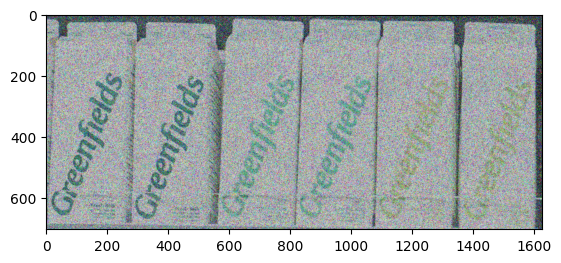

In [7]:
import cv2

def denoise_image(image):
    # Applica il filtro bilaterale per il denoising
    denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised_image

# Utilizza l'immagine rumorosa come input
# noisy_image = add_noise_to_image(cv2.imread(f'/Users/pelle/Desktop/scene12.png')[:,:,::-1], 
#                                  "random", 
#                                  {"intensity": 80})
# Applica il denoising all'immagine rumorosa
denoised_image = denoise_image(cv2.imread(f'/Users/pelle/Desktop/scene12.png')[:,:,::-1])

# Mostra l'immagine originale, l'immagine rumorosa e l'immagine denoised
plt.imshow(denoised_image); plt.show()

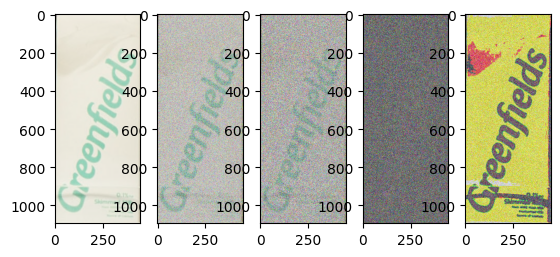

In [22]:
import numpy as np

def recover_original_image(noisy_image, noise_parameters):
    # Estrai il rumore aggiunto
    noise = np.random.normal(scale=noise_parameters['intensity'], size=noisy_image.shape)
    
    # Rimuovi il rumore dall'immagine rumorosa per recuperare l'immagine originale
    original_image = np.clip(noisy_image + noise, 0, 255).astype(np.uint8)
    
    return original_image

image = cv2.imread("/Users/pelle/Desktop/ref18.png")

# Utilizza l'immagine rumorosa come input
noisy_image = add_noise_to_image(image, "random", {"intensity": 100})

# Recupera un'approssimazione dell'immagine originale
recovered_image = recover_original_image(noisy_image, {"intensity": 100})

# Mostra l'immagine originale, l'immagine rumorosa e l'immagine recuperata
plt.subplot(151); plt.imshow(image)
plt.subplot(152); plt.imshow(noisy_image)
plt.subplot(153); plt.imshow(recovered_image)

plt.subplot(154); plt.imshow(recovered_image - noisy_image)
plt.subplot(155); plt.imshow(noisy_image - image)

